# QPE: example of application in engineering problems 



Some problmes in science and engineering can be solved by only finding the eigenvalues of the system. This notebook shows 2 examples of solving engineering problems by finding eigenvalues with QPE.

The first example is stability of structures, in particular buckling of a beam. In this case the smallest eigenvalue determines the load at which the structure will fail. 

The second example shows how finding eigenvalues with QPE can be applied in modal analysis for finding resonance frequencies of structures.

Both problems are formulated with finite elements approach in such way that they are fully scalable. This means that they can be easily extended to any number of elements which allow for modelling structures with much more complex geometries.
Considering that in practice such models can easily reach sizes in order of 100,000 - 1,000,000 elements, applying QPE for finding eigenvalues has a chance to provide with significant speed up of the procedure, especially for larger systems. 



##  1. Buckling analysis

The problem of buckling is of great interest in structural mechanics, as buckling is often the reson of rapid premature failre. One of the most most simple examples is buckling of a slender beam loaded in compression.
<table><tr><td><img src='images/Buckled_column.png'></td><td><img src='images/buckling_example.jpg'></td></tr></table>


### 1.1 Problem formulation

Buckling analysis is formulated as an eigenvalues problem:
\begin{align}
(K_0 + \lambda K_1)\delta u = 0
\end{align}

where $K_0$ and $K_1$ are stiffness matrices, with entries that depend on geometry and material properties of the elements.

In this example the beam is modeled as a single element with 2 nodes and 6 Degrees of freedom using Finite Elements approach. This yields 6x6 system, which after applying boundary conditions can be reduced to 2x2 system. Such small system can be easily solved on a real Quantum computer.

### 1.2 Preparing the system matrix

In [3]:
import numpy as np
#from qiskit import available_backends
import sys
sys.path.append("..")
from qpe_hhl.qpe import QPE
#import matplotlib.pyplot as plt
from demo_functions import plot_res_and_theory, initiate_q_backend, Efr

E = 200e9
I = 1000*10**(-12)
L = 1.

P = 1.
K0 =  E* I/L* np.matrix([[4,2],[2,4]])
K1 = P*L**2/(30*L)*np.matrix([[4,-1],[-1,4]])
K = np.linalg.inv(K1)*K0

### 1.3 Setting  up algorithm parameters

In [4]:
#initiate_q_backend()
hermitian_matrix = True
n = len(K)
k = 3
invec = ([1,2])
nege = True


params = {
    'algorithm': {
            'name': 'QPE',
            'num_ancillae': k,
            'num_time_slices': 3,
            'expansion_mode': 'suzuki',
            'expansion_order': 2,
            'hermitian_matrix': True,
            'negative_evals': nege,
            'backend' : "local_qasm_simulator",
            #'backend' : "ibmqx5",
            #'evo_time': 2*np.pi/4,
            #'use_basis_gates': False,
    },
    "iqft": {
        "name": "STANDARD"
    },
    "initial_state": {
        "name": "CUSTOM",
        "state_vector": invec
    }
}

### 1.4 Executing the algorithm

In [6]:
import matplotlib.pyplot as plt
qpe = QPE()
qpe.init_params(params, K)
qc = qpe._compute_eigenvalue()

COMPLETED
{'backend': 'local_qasm_simulator_py', 'id': 'c7e43f4c-c987-4253-b356-13c808e5befd', 'job_id': 'b33dec34-9df8-4193-b07f-c0122bfd8575', 'result': [{'name': 'circuit6', 'seed': 561890395, 'shots': 1024, 'data': {'counts': {'110': 910, '100': 70, '000': 31, '010': 4, '111': 5, '001': 1, '101': 1, '011': 2}, 'snapshots': {}}, 'status': 'DONE', 'success': True, 'time_taken': 11.031195402145386}], 'status': 'COMPLETED', 'success': True, 'time_taken': 11.031260967254639}


### 1.5 Results

In [ ]:
res = qpe._ret
plot_res_and_theory(res, K, k, nege)
Eigs = Efr(res)
print('The beam buckles at ', np.min(Eigs), ' N')

## 2. Finding Resonance frequency of a structure


In design of a structure one is often interested in its response to vibrations, and in particular in finding the resonance frequency spectrum.

An example of such problem can be a design of an earthquake resistant building. Lets take an example of a 2 storey building, where the storeys are modelled as masses connected with springs. 

<table><tr><td><img src='images\building.jpg'width="300 px" ></td><td><img src='images\springs.png' width="200 px" ></td></tr></table>

The goverinng equation ce be then written in a matrix form as:
\begin{align}
Mx'' = Kx 
\end{align}
where M and K are mass and stiffness matrices respectively. Then solving eigenvalues of the system one can obtain frequencies as $\omega = \sqrt{- \lambda}$

### 2.2 Preparing the system matrix

In [18]:
k0 = 30000
k1 = 30000

m1 = 30000 #kg
m2 = 30000 #kg

M = np.matrix(np.diag([m1,m2]))
K0 = np.matrix([[-(k0+k1), k1], [k1, -k1]])

K = np.linalg.inv(M)*K0
p, v = np.linalg.eig(K)
print(K)
print(p)
print(v)

[[-2.  1.]
 [ 1. -1.]]
[-2.61803399 -0.38196601]
[[-0.85065081 -0.52573111]
 [ 0.52573111 -0.85065081]]


### 2.3 Setting up the algorithm parameters

In [17]:
hermitian_matrix = True
n = len(K)
k = 4
invec = ([1,2])
nege = True

params = {
    'algorithm': {
            'name': 'QPE',
            'num_ancillae': k,
            'num_time_slices': 3,
            'expansion_mode': 'suzuki',
            'expansion_order': 2,
            'hermitian_matrix': True,
            'negative_evals': nege,
            'backend' : "local_qasm_simulator",
            #'backend' : "ibmqx5",
            #'evo_time': 2*np.pi/4,
            #'use_basis_gates': False,
    },
    "iqft": {
        "name": "STANDARD"
    },
    "initial_state": {
        "name": "CUSTOM",
        "state_vector": invec
    }
}

### 2.4 Executing the algorithm

In [11]:
qpe = QPE()
qpe.init_params(params, K)
qc = qpe._compute_eigenvalue()

res = qpe._ret

COMPLETED
{'backend': 'local_qasm_simulator_py', 'id': 'f1945715-f147-4e8c-a85a-6278ecaf4b65', 'job_id': '1e584503-c3a1-4613-90dc-9217598b2cad', 'result': [{'name': 'circuit17', 'seed': 3069818630, 'shots': 1024, 'data': {'counts': {'0000': 27, '1111': 946, '0111': 19, '1011': 4, '0100': 5, '1001': 2, '0011': 5, '0101': 10, '1110': 1, '1101': 2, '0110': 1, '0001': 1, '1000': 1}, 'snapshots': {}}, 'status': 'DONE', 'success': True, 'time_taken': 37.684176445007324}], 'status': 'COMPLETED', 'success': True, 'time_taken': 37.68422818183899}


### 2.5 Results

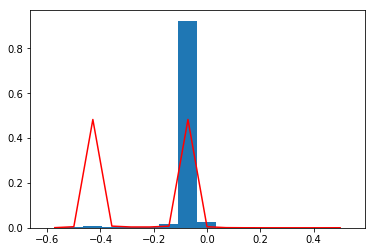

Eigenvalues: [-0.  0.]
Resonance frequencies: [ 0. -0.] Hz


In [13]:
plot_res_and_theory(res, K, k, nege)
print('Eigenvalues:', Efr(res))
print('Resonance frequencies:', np.sqrt(-Efr(res))/(2*np.pi), 'Hz')

#print(res['measurements'])